In [1]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical
import tqdm
import re
from functools import cmp_to_key

warnings.filterwarnings("ignore")

with open("../../datasets/anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [2]:
text[118:500]

'|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

In [3]:
# Разбитие на анектоды
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]
cut_text = cut_data(text)

In [4]:
import random
cut_text[random.randint(0, 31000)]

'Лайфхак. Положив сахар в чай, не размешивайте его до тех пор, пока не дойдете до своего компьютера. Та лужа, которую вы сделаете по пути, будет нелипкая и несладкая, и вы сможете спокойно вытереть ее своим носком.'

In [5]:
allowed_symbols = {'\n', ':', ';', '=', '>', '?', '@', ' ', '!', '"', '#', '$', '%', '&', '\'', '*', '+', ',', '\-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Ё', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё'}

allowed_symbols2 = {'\n', ':', ';', '=', '>', '?', '@', ' ', '!', '"', '#', '$', '%', '&', '\'', '*', '+', ',', '\-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Ё', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё'}

allowed_symbols2_rus = {':', ';', '?', '@', ' ', '!', '"', '#', '$', '%', '*', '+', ',', '\-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9','Ё', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё'}

In [6]:
GLOBAL_MAX_TOKEN_LEN = 2
GLOBAL_MAX_TOKEN_COUNT = 61

# Задание 4. RNN
## Задача 1. 3 балла
Обучите RNN/LSTM на данных из классной работы, используя другой токенайзер. Опишите его и свой выбор. Покажите разницу в генерации моделей, обученных с разными токенайзерами.
## {*} Задача 1.1 2 балла
Напишите свой токенайзер вручную, с использованием только библиотек numpy, torch, sklearn, stats, опционально других пакетов, не предоставляющих готовые инструменты токенизации и т.п., за исключением предобработки текста (лемматизация, стеминг и т.д.) . 


In [7]:
class Custom_Tokenizer:
    def __init__(self, cut_text, max_count_token: int = 512, max_token_len = 2, allowed_s = allowed_symbols2_rus):
        self.allowed_s = allowed_s
        self.max_token_len = max_token_len
        self.text = cut_text
        self.max_count_token = max_count_token
        self.specials = {'<pad>':999999, '<bos>':999999, '<eos>':999999}
        
        self.create_vocab("".join(self.text))
        
    def token_compare(self, item1:dict, item2:dict):
        if ((" " in item1[0] or " " in item2[0]) and not(item1[0] == " " or item2[0] == " ")):
            #print(item1[0], item2[0])
            if (" " in item1[0] and " " in item2[0]):
                return 0
            elif (" " in item1[0]):
                return 1
            else:
                return -1
        else:
            #if (len(item2[0]) > len(item1[0]) and item2[0])
            return item2[1] - item1[1]
    
    def create_vocab(self, text: str):
        regex = r'[^' + "".join(self.allowed_s).lower() + ']'
        reg = re.compile(regex)
        text = reg.sub('', text.replace('ё', 'е'))
    
        my_dict = {}
        i = 1
        text_len = len(text)
        for index in range(0, text_len - i + 1):
            token = text[index:index+i]
            if not token in my_dict:
                my_dict[token]=9999999
    
        text = re.sub(r'[^а-я ]', '', text)

    
        for i in range (2, self.max_token_len+1):
            text_len = len(text)
            for index in range(0, text_len - i + 1):
                token = text[index:index+i]
                if token in my_dict:
                    my_dict[token]+=1
                else:
                    my_dict[token]=1
                # Assign unique IDs to tokens
        
        # отсортировали по принципу с пробелом в конец, 1 символ в начало,
        #   остальное по частоте, чтобы лего сделать crop
        sorted_tokens = dict(sorted(my_dict.items(), key=cmp_to_key(self.token_compare))[:self.max_count_token])
        # Сортируем по длине токена, а после по частоте
        sorted_tokens.update(self.specials)

        sorted_tokens = sorted(sorted_tokens.items(), key=lambda x: (-len(x[0]), -x[1]))

        self.token_to_id = {token: idx for idx, (token, _) in enumerate(sorted_tokens)}
        self.id_to_token = {idx: token for token, idx in self.token_to_id.items()}
    
    def _add_special(self, symbol) -> None:
        # add special characters to yuor dicts
        sym_num = len(self.token_to_id)
        self.token_to_id[symbol] = sym_num
        self.id_to_token[sym_num] = symbol
    
    @property
    def vocab_size(self):
        return len(self.token_to_id) # your code
    
    def decode_symbol(self, el):
        return self.id_to_token[el]
        
    def encode_symbol(self, el):
        return self.token_to_id[el]

    #@property
    def tokenize(self, text: str):
        """
        Tokenizes the input text into numbers using the built dictionary.
        :param text: Input text to tokenize.
        :return: A list of token IDs representing the text.
        """
        
        if not self.token_to_id:
            raise ValueError("Tokenizer dictionary is empty. Call 'build_dict' first.")
        
        tokens = []
        i = 0
        while i < len(text):
            match = None
            # Try to find the longest matching token
            for size in range(max(self.max_token_len, 5), 0, -1):
                if i + size <= len(text):
                    substring = text[i:i + size]
                    if substring in self.token_to_id:
                        match = substring
                        break
            
            if match:
                tokens.append(self.token_to_id[match])
                i += len(match)  # Move past the matched token
            else:
                # If no match, handle single characters (fallback)
                tokens.append(self.token_to_id[text[i]])
                i += 1
        
        return tokens
    
    def detokenize(self, token_ids):
        """
        Converts token IDs back into the original text using the dictionary.
        :param token_ids: A list of token IDs.
        :return: The reconstructed text.
        """
        return ''.join(self.id_to_token[token_id] for token_id in token_ids)
    
    def encode(self, chars, eos=True):
        regex = r'[^' + "".join(self.allowed_s) + ']'
        reg = re.compile(regex)
        chars = reg.sub('', chars.lower().replace('ё', 'е'))

        if eos:
            chars = '<bos>' + chars + '<eos>'
        else:
            chars = '<bos>' + chars
        return self.tokenize(chars)

    def decode(self, idx):
        return self.detokenize(idx)

In [8]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode_symbol("<pad>")
    
    def __len__(self):
        return len(self.cut_text)
    
    def __getitem__(self, item):
        #  в идеале запонлять паддингами лучше в другом месте
        encoded = self.tokenizer.encode(self.cut_text[item])[:self.max_len]
        padded = torch.full((self.max_len, ), self.pad_index, dtype=torch.long)
        padded[:len(encoded)] = torch.tensor(encoded)
        # pad your sequence and make a final sample. You can skip padding and pad sequences with torch special method.
        return padded, len(encoded)

# Optionally add new methods to your dataset class

## Задача 2. 3 балла
Реализуйте с помощью только torch/numpy слой RNN, обучите его на данных из классной работы и, опционально, своих данных. Покажите, что модель обучается
## {*} Задача 2.1 +1 балл
За реализацию слоев GRU/LSTM/bidirectional RNN, многослойной модели по +1 баллу к базовым (даже если ванильная RNN не реализована)

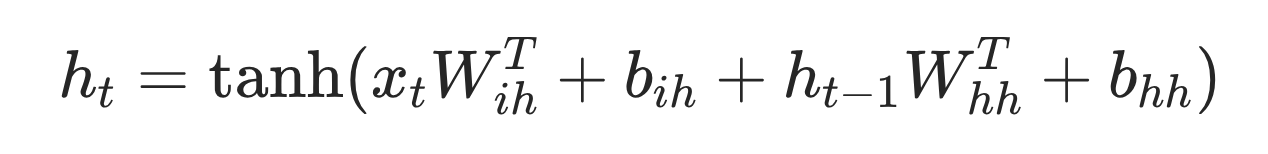
```python
self.rnn = nn.RNN(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
        )
```

# Вопроc: зачем num_layers?

In [ ]:
class CustomRNN(nn.Module):
    def __init__(
            self,
            hidden_size:int,
            seq_len:int):
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.hidden_size = hidden_size        
        
        super().__init__()
        self.hidden_size = hidden_size
        
        

        # Кратко поясню: сходимости не было, был либо разброс,
        #   либо затухание, поэтому nn

        self.Lh = nn.Linear(hidden_size, hidden_size)
        self.Lx = nn.Linear(hidden_size, hidden_size)
        #self.Wh = torch.rand(hidden_size, hidden_size, dtype=torch.float32, requires_grad=True)
        #self.Wx = torch.rand(hidden_size, hidden_size, dtype=torch.float32, requires_grad=True)
        self.Lh = torch.nn.utils.spectral_norm(self.Lh)
        self.Lx = torch.nn.utils.spectral_norm(self.Lx)

        self.bh = torch.rand((1, hidden_size), dtype=torch.float32, requires_grad=True)

    def forward(self, x):
        h_0 = torch.zeros((1, self.hidden_size), dtype=torch.float32)
        
        h_t_minus_1 = h_0
        h_t = h_0
        output = []
        print(len(x[0]))
        for t in range(len(x[0])):
            #h_t = torch.tanh(
            #    x[t] @ self.Wx.T
            #    + h_t_minus_1 @ self.Wh.T
            #    + self.bh
            #)
            h_t = self.Lh(h_t_minus_1) + self.Lx(x[0][t]) + self.bh
            output.append(h_t)
            h_t_minus_1 = h_t
        
        output = torch.stack(output)
        output = output.transpose(0, 1)
        return output, None #h_t.unsqueeze(0)

In [10]:
class CharRNN(nn.Module):
    
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_text_len: int = 512, # Максимальная длина сообщения в символах
    ) -> None:
        '''    hidden_dim: Длинна словаря (количество ожидаемых признаков во входных данных x)
               max_len: Максимальная длина сообщения в символах
        '''
        
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_text_len = max_text_len
        # create mappings
        self.tokenizer = tokenizer

        ## define the LSTM, dropout and fully connected layers
        self.encoder = nn.Embedding(self.tokenizer.vocab_size, self.hidden_dim)
        self.rnn = CustomRNN(
            hidden_size=self.hidden_dim,
            seq_len=4
        )
        #self.rnn = nn.LSTM(
        #    input_size=self.hidden_dim,
        #    hidden_size=self.hidden_dim,
        #    num_layers=1,
        #    batch_first=True,
        #    dropout=self.drop_prob
        #)


        self.dropout = nn.Dropout(p=self.drop_prob)
        self.decoder = nn.Linear(
            in_features=self.hidden_dim,
            out_features=self.tokenizer.vocab_size,
        )

    # Forward - это проход вперёд по слою
    def forward(
        self, x: torch.Tensor, lengths: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # one-hot encode your sequence
        packed_embeds = self.encoder(x) # pack your sequence. This helps with the efficiency. Use torch function pack_padded_sequence
        outputs, hidden = self.rnn(packed_embeds) # run you model
        #print(outputs)
        # TODO: Понять нафига
        #  out, lengths = # pad sequence back
        
        # Pass through a dropout layer and fully connected layer
        out = self.dropout(outputs)
        ## Get the output for classification.
        out = self.decoder(out)

        return out, hidden

    
    # инференс - режим не обучения (По сути штатная работа)
    def inference(self, prefix='<bos> ', device="cpu"):
        tokens = torch.tensor([self.tokenizer.encode(prefix, eos=False)], device=device) # encode prefix
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        # Generate sequence iteratively
        for _ in range(self.max_text_len - len(tokens[0])):
            # YOUR CODE: generate sequence one by one
            # Pass tokens through the embedding layer
            logits, hidden = self.forward(tokens, torch.tensor([tokens.size(1)]))
            
            # Get the last token's logits and sample a token
            next_token_logits = logits[:, -1, :]
            new_token = torch.multinomial(
                torch.nn.functional.softmax(next_token_logits, dim=-1), num_samples=1
            )

            # Append the new token
            tokens = torch.cat([tokens, new_token], dim=1)

            # Stop if the <eos> token is generated
            if new_token.item() == self.tokenizer.encode_symbol("<eos>"):
                break
        # Decode the token IDs back into a string
        return self.tokenizer.decode(tokens.squeeze().tolist())


In [11]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    inputs, lengths = train_batch
    inputs = inputs.to(device)
    lengths = lengths.to(device)

    # Сброс градиентов
    optimizer.zero_grad()

    # Прямой проход
    outputs, _ = model(inputs[:, :-1], lengths)

    # Переформатирование выходов и целевых меток для расчета функции потерь
    outputs = outputs.view(-1, vocab_size)
    targets = inputs[:, 1:].reshape(-1)

    # Вычисление функции потерь
    loss = criterion(outputs, targets)

    # Обратный проход
    loss.backward()

    # Шаг оптимизации
    optimizer.step()
    return loss.item()

In [12]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [13]:
batch_size = 1
n_hidden = 512 # 10+3 #64 #256
n_layers = 1 #4
drop_prob = 0.1
lr = 0.001

num_epochs = 1
device = 'cpu'

In [14]:
tokenizer = Custom_Tokenizer(cut_text,
                             max_count_token=GLOBAL_MAX_TOKEN_COUNT,
                             max_token_len = GLOBAL_MAX_TOKEN_LEN,
                             allowed_s = allowed_symbols2_rus)

In [15]:
model = CharRNN(tokenizer, hidden_dim=n_hidden, num_layers=n_layers, drop_prob=drop_prob)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model = model.to(device)

In [16]:
dataset = JokesDataset(tokenizer, cut_text, 256)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [17]:
next(iter(dataloader))

[tensor([[ 1, 13, 33, 38, 16,  9, 33, 10, 22,  6,  7, 14, 11, 25,  6, 10, 11,  4,
          15,  8, 10, 39, 10, 19, 33, 13, 14, 20, 10, 24, 12, 11, 32, 14, 15,  8,
          10, 38, 14, 25, 41, 16, 25, 33, 10, 11, 12, 10, 22, 27, 15,  8, 10, 13,
          16, 25, 33, 15, 17, 10, 22, 24, 16, 32, 14, 15, 19, 27, 10,  6, 32, 14,
          20, 12, 15,  8, 10, 14, 14, 10, 20, 19, 40, 10, 38, 16, 11, 25,  8, 31,
          31, 31,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0

In [18]:
losses = []

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    with tqdm.tqdm(total=len(dataloader)) as prbar:
        for i, batch in enumerate(dataloader):
            loss = training_step(model, batch, tokenizer.vocab_size, criterion, optimizer, device)
            epoch_loss += loss
        
            if i % 100 == 0:
                #print(f'Done {i/len(dataloader) * 100:.2f}%, Loss: {loss:.4f}')
                metrics_str = f"Loss: {round(loss, 4)} "
                #for k, v in metrics_dict.items():
                #    metrics_str += f"{k}: {round(float(v), 4)} "
                prbar.set_description(metrics_str)
                prbar.update(100)
    
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    plot_losses(losses)
    #torch.save(model.state_dict(), "rnn.pt")
    torch.save(model, "rnn.pt")

  0%|          | 0/124155 [00:00<?, ?it/s]

255


Loss: 4.4596 :   0%|          | 100/124155 [00:00<06:49, 302.74it/s]

255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255


Loss: 4.4596 :   0%|          | 100/124155 [00:19<06:49, 302.74it/s]

255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255


Loss: 0.5782 :   0%|          | 200/124155 [00:25<5:08:01,  6.71it/s]

255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255


Loss: 0.5782 :   0%|          | 200/124155 [00:34<5:53:56,  5.84it/s]

255


KeyboardInterrupt: 

In [ ]:
#model.load_state_dict(torch.load("rnn.pt", weights_only=True))
model = torch.load("rnn.pt", weights_only=False)


model.eval()

In [19]:
[model.inference("Пилите, Шура, пилите. Они ", device=device) for _ in range(10)]

27


IndexError: index 27 is out of bounds for dimension 0 with size 27

## Задача 3. 1/2/3/4 балла
**TBD**: 
Попробуйте обучить рекуррентную сеть задаче классификации. Вы можете воспользоваться сторонними библиотеками для вашей работы, 
но модель и основной код должны быть написаны на pytorch. 

##  {*} Задача 4. 5/6/7/8 баллов
[ссылка](https://www.kaggle.com/t/b2ef08dc3ddf44f981e2ad186c6c508d)

Попробуйте обучить сверточную нейронную сеть задаче детекции людей на изображениях разного стиля. Вы можете воспользоваться сторонними библиотеками для вашей работы. Однако, за неисопользование полностью готовых скриптов обучения (как в классной работе) вы получите дополнительные2 балла